In [1]:
import numpy as np
import pandas as pd
from time import time, sleep
import gc

### Load the dataset

In [2]:
app_train = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
app_test = pd.read_csv('../input/home-credit-default-risk/application_test.csv')
bureau = pd.read_csv('../input/home-credit-default-risk/bureau.csv')
bureau_balance = pd.read_csv('../input/home-credit-default-risk/bureau_balance.csv')
pos_cash_balance = pd.read_csv('../input/home-credit-default-risk/POS_CASH_balance.csv')
credit_card_balance = pd.read_csv('../input/home-credit-default-risk/credit_card_balance.csv')
previous_application = pd.read_csv('../input/home-credit-default-risk/previous_application.csv')
installments_payments = pd.read_csv('../input/home-credit-default-risk/installments_payments.csv')

print('app_train.shape: {}'.format(app_train.shape))
print('app_test.shape: {}'.format(app_test.shape))
print('bureau.shape: {}'.format(bureau.shape))
print('bureau_balance.shape: {}'.format(bureau_balance.shape))
print('pos_cash_balance.shape: {}'.format(pos_cash_balance.shape))
print('credit_card_balance.shape: {}'.format(credit_card_balance.shape))
print('previous_application.shape: {}'.format(previous_application.shape))
print('installments_payments.shape: {}'.format(installments_payments.shape))

app_train.shape: (307511, 122)
app_test.shape: (48744, 121)
bureau.shape: (1716428, 17)
bureau_balance.shape: (27299925, 3)
pos_cash_balance.shape: (10001358, 8)
credit_card_balance.shape: (3840312, 23)
previous_application.shape: (1670214, 37)
installments_payments.shape: (13605401, 8)


### Drop the outliers

In [3]:
app_train = app_train[app_train.CODE_GENDER!='XNA']
app_train = app_train[app_train.AMT_INCOME_TOTAL<20000000]

### Combine the dataset for easy processing

In [4]:
app_train['istestset'] = 0
app_test['istestset'] = 1

combine = pd.concat([app_train.drop('TARGET', axis=1), app_test], axis=0, ignore_index=True)
print('combine.shape: {}'.format(combine.shape))

combine.shape: (356250, 122)


### Fill in missing values & Feature engineering

In [5]:
binary_features = [
    'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
    'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION',
    'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
    'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
    'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
    'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
    'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'
]

categorical_features = [
    'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
    'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
    'REGION_POPULATION_RELATIVE'
]

numeric_features = [
    'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
    'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START', 'REGION_RATING_CLIENT',
    'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
    'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
    'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
    'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
    'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE',
    'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
    'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
    'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI',
    'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
    'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE',
    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'
]

todrop_features = [
    'SK_ID_CURR'
]

#### Deal with missing values

In [6]:
# Fill in NAME_TYPE_SUITE with mode
combine['NAME_TYPE_SUITE'] = combine.NAME_TYPE_SUITE.fillna(combine.NAME_TYPE_SUITE.mode()[0])

# Fill in NAME_FAMILY_STATUS with mode
combine['NAME_FAMILY_STATUS'] = combine.NAME_FAMILY_STATUS.fillna(combine.NAME_FAMILY_STATUS.mode()[0])

# Fill in OCCUPATION_TYPE with None
combine['OCCUPATION_TYPE'] = combine.OCCUPATION_TYPE.fillna('NONE')

# Fill in CNT_FAM_MEMBERS with median
combine['CNT_FAM_MEMBERS'] = combine.CNT_FAM_MEMBERS.fillna(combine.CNT_FAM_MEMBERS.median())

# Fill in APARTMENTS related categorical features with None
apartment_related_categorical_features = [
    'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'
]
for feat in apartment_related_categorical_features:
    combine[feat] = combine[feat].fillna('NONE')

#### Feature engineering

##### Feature engineering within the main application table

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for feat in binary_features:
    combine[feat] = le.fit_transform(combine[feat])
    
for feat in categorical_features:
    combine[feat] = combine[feat].astype('category')
    
# Create a CONSUMER_LOAN feature based on whether it's consumer loan or not
combine['CONSUMER_LOAN'] = combine.AMT_GOODS_PRICE.notnull().astype(int)

# Change those too large DAYS_EMPLOYED values to no.nan
combine.loc[combine.DAYS_EMPLOYED>300000, 'DAYS_EMPLOYED'] = np.nan

# Change those zeros in DAYS_LAST_PHONE_CHANGE to np.nan
combine.loc[combine.DAYS_LAST_PHONE_CHANGE==0, 'DAYS_LAST_PHONE_CHANGE'] = np.nan

# Create several ratio based features:
combine['AMT_CREDIT_OVER_INCOME'] = combine['AMT_CREDIT'] / combine['AMT_INCOME_TOTAL']
combine['AMT_GOODS_PRICE_OVER_INCOME'] = combine['AMT_GOODS_PRICE'] / combine['AMT_INCOME_TOTAL']
combine['AMT_ANNUITY_OVER_INCOME'] = combine['AMT_ANNUITY'] / combine['AMT_INCOME_TOTAL']
combine['AMT_ANNUITY_OVER_CREDIT'] = combine['AMT_ANNUITY'] / combine['AMT_CREDIT']
combine['AMT_GOODS_PRICE_OVER_CREDIT'] = combine['AMT_GOODS_PRICE'] / combine['AMT_CREDIT']
combine['AMT_GOODS_PRICE_OVER_ANNUITY'] = combine['AMT_GOODS_PRICE'] / combine['AMT_ANNUITY']
combine['DAYS_BIRTH_OVER_DAYS_EMPLOYED'] = combine['DAYS_BIRTH'] / combine['DAYS_EMPLOYED']
combine['OWN_CAR_AGE_OVER_DAYS_BIRTH'] = combine['OWN_CAR_AGE'] / (- combine['DAYS_BIRTH'] / 365)
combine['OWN_CAR_AGE_OVER_DAYE_EMPLOYED'] = combine['OWN_CAR_AGE'] / (- combine['DAYS_EMPLOYED'] / 365)
combine['DAYS_LAST_PHONE_CHANGE_OVER_DAYS_BIRTH'] = combine['DAYS_LAST_PHONE_CHANGE'] / combine['DAYS_BIRTH']
combine['DAYS_LAST_PHONE_CHANGE_OVER_DAYS_EMPLOYED'] = combine['DAYS_LAST_PHONE_CHANGE'] / combine['DAYS_EMPLOYED']

combine['AMT_INCOME_TOTAL_OVER_CNT_CHILDREN'] = combine['AMT_INCOME_TOTAL'] / combine['CNT_CHILDREN']
combine['AMT_INCOME_TOTAL_OVER_CNT_FAM_MEMBERS'] = combine['AMT_INCOME_TOTAL'] / combine['CNT_FAM_MEMBERS']

combine['AMT_INCOME_TOTAL_OVER_DAYS_EMPLOYED'] = combine['AMT_INCOME_TOTAL'] / combine['DAYS_EMPLOYED']
combine['AMT_INCOME_TOTAL_OVER_DAYS_BIRTH'] = combine['AMT_INCOME_TOTAL'] / combine['DAYS_BIRTH']

combine['DAYS_EMPLOYED_OVER_DAYS_BIRTH'] = combine['DAYS_EMPLOYED'] / combine['DAYS_BIRTH']

# Create EXT_SOURCE_MEAN, EXT_SOURCE_STD, CNT_EXT_SOURCE
ext_source_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
combine['EXT_SOURCE_MEAN'] = combine[ext_source_features].mean(axis=1)
combine['EXT_SOURCE_STD'] = combine[ext_source_features].std(axis=1)
combine['CNT_EXT_SOURCE'] = combine[ext_source_features].count(axis=1)

# Create CNT_DOCUMENTS
document_related_features = [_ for _ in combine.columns if 'DOCUMENT' in _]
combine['CNT_DOCUMENTS'] = combine[document_related_features].sum(axis=1)

# Create CNT_CONTACT_INFO
contact_info_related_features = ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL']
combine['CNT_CONTACT_INFO'] = combine[contact_info_related_features].sum(axis=1)

##### Grab more feature from other tables

In [8]:
print('Preparing BUREAU, LAST_BUREAU, ACTIVE_BUREAU and CLOSED_BUREAU...')
sk_id_bureau = bureau_balance.groupby('SK_ID_BUREAU').SK_ID_BUREAU.agg(['size'])
sk_id_bureau.columns = ['BUREAU_BALANCE_'+'SK_ID_BUREAU_'+_.upper() for _ in sk_id_bureau.columns]
months_balance = bureau_balance.groupby('SK_ID_BUREAU').MONTHS_BALANCE.agg(['mean'])
months_balance.columns = ['BUREAU_BALANCE_'+'MONTHS_BALANCE_'+_.upper() for _ in months_balance.columns]
status = bureau_balance.groupby('SK_ID_BUREAU').STATUS.value_counts().unstack().fillna(0)
status.columns = ['BUREAU_BALANCE_'+'STATUS_'+_.upper() for _ in status.columns]

bureau = pd.merge(bureau, months_balance, how='left', on='SK_ID_BUREAU')
bureau['AMT_CREDIT_SUM_DEBT_OVER_AMT_CREDIT_SUM'] = bureau['AMT_CREDIT_SUM_DEBT'] / bureau['AMT_CREDIT_SUM']
bureau['AMT_CREDIT_SUM_MINUS_AMT_CREDIT_SUM_DEBT'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
bureau['CREDIT_DURATION'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_CREDIT']
bureau['AMT_CREDIT_SUM_OVER_AMT_ANNUITY'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']


active_bureau = bureau[bureau.CREDIT_ACTIVE=='Active'].select_dtypes(exclude='object').drop('SK_ID_BUREAU', axis=1)
closed_bureau = bureau[bureau.CREDIT_ACTIVE=='Closed'].select_dtypes(exclude='object').drop('SK_ID_BUREAU', axis=1)

bureau = pd.merge(bureau, sk_id_bureau, how='left', on='SK_ID_BUREAU')
bureau = pd.merge(bureau, status, how='left', on='SK_ID_BUREAU')

last_days_credit = bureau.groupby('SK_ID_CURR').DAYS_CREDIT.max()
last_bureau = pd.merge(last_days_credit, bureau, how='left', on=['SK_ID_CURR', 'DAYS_CREDIT'])
last_bureau = last_bureau.drop_duplicates(['SK_ID_CURR'])
last_bureau = pd.get_dummies(last_bureau).drop('SK_ID_BUREAU', axis=1)

other_features = [_ for _ in bureau.columns if _ not in active_bureau.columns]
bureau = pd.concat([bureau[bureau.columns[:2]], bureau[other_features]], axis=1).drop('SK_ID_BUREAU', axis=1)

print('Preparing PREVIOUS_APPLICATION...')
# Change too large DAYS in previous_application to np.nan
previous_application['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
previous_application['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
previous_application['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
previous_application['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
# previous_application = previous_application[previous_application.FLAG_LAST_APPL_PER_CONTRACT=='Y']

# Create some more features from previous_application
previous_application['AMT_APPLICATION_OVER_AMT_CREDIT'] = previous_application['AMT_APPLICATION'] / previous_application['AMT_CREDIT']
previous_application['AMT_APPLICATION_MINUS_AMT_CREDIT'] = previous_application['AMT_APPLICATION'] - previous_application['AMT_CREDIT']
previous_application['AMT_CREDIT_OVER_AMT_ANNUITY'] = previous_application['AMT_CREDIT'] / previous_application['AMT_ANNUITY']
previous_application['AMT_DOWN_PAYMENT_OVER_AMT_CREDIT'] = previous_application['AMT_DOWN_PAYMENT'] / previous_application['AMT_CREDIT']
previous_application['AMT_DOWN_PAYMENT_OVER_AMT_ANNUITY'] = previous_application['AMT_DOWN_PAYMENT'] / previous_application['AMT_ANNUITY']
previous_application['INTREST'] = (previous_application['AMT_ANNUITY'] * previous_application['CNT_PAYMENT']) / previous_application['AMT_CREDIT'] - 1



print('Preparing INSTALLMENTS_PAYMENTS...')
# Create some more features from installments_payments
installments_payments['AMT_PAYMENT_OVER_AMT_INSTALMENT'] = installments_payments['AMT_PAYMENT'] / installments_payments['AMT_INSTALMENT']
installments_payments['AMT_INSTALMENT_MINUS_AMT_PAYMENT'] = installments_payments['AMT_INSTALMENT'] - installments_payments['AMT_PAYMENT']
installments_payments['DPD'] = installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT']
installments_payments['DBD'] = installments_payments['DAYS_INSTALMENT'] - installments_payments['DAYS_ENTRY_PAYMENT']
installments_payments['DPD'] = installments_payments['DPD'].apply(lambda x: x if x > 0 else 0)
installments_payments['DBD'] = installments_payments['DBD'].apply(lambda x: x if x > 0 else 0)

the_zip = zip(
    [bureau, active_bureau, closed_bureau, pos_cash_balance, credit_card_balance, previous_application, installments_payments], 
    ['BUREAU_', 'ACTIVE_BUREAU_', 'CLOSED_BUREAU_', 'POS_CASH_BALANCE_', 'CREDIT_CARD_BALANCE_', 'PREVIOUS_APPLICATION_', 'INSTALLMENTS_PAYMENTS_']
)

# print('combine.shape: {}'.format(combine.shape))
print('Extracting information from LAST_BUREAU...')
combine = pd.merge(combine, last_bureau, how='left', on='SK_ID_CURR')
# print('combine.shape: {}'.format(combine.shape))

for df, df_name_pref in the_zip:
    print('Extracting information from {}...'.format(df_name_pref[:-1]))
    info_dict = {feat: (lambda x: 'value_counts' if df[x].dtype=='object' else ['min', 'max', 'mean', 'std', 'sum', 'count'])(feat) for feat in df.columns[2:]}
    info_dict['SK_ID_CURR'] = ['count']
    for feat in info_dict.keys():
        info = info_dict[feat]
        if isinstance(info, list):
            tmp_info_df = df.groupby('SK_ID_CURR')[feat].agg(info)
            tmp_info_df.columns = [df_name_pref+feat+'_'+_.upper() for _ in tmp_info_df.columns]
            combine = pd.merge(combine, tmp_info_df, how='left', on='SK_ID_CURR')
        else:
            tmp_info_df = df.groupby('SK_ID_CURR')[feat].value_counts().unstack().fillna(0)
            tmp_info_df.columns = [df_name_pref+feat+'_'+_.upper() for _ in tmp_info_df.columns]
            combine = pd.merge(combine, tmp_info_df, how='left', on='SK_ID_CURR')
#     print('combine.shape: {}'.format(combine.shape))
    
del [bureau, active_bureau, closed_bureau, pos_cash_balance, credit_card_balance, previous_application, installments_payments]
gc.collect()
print('Done')

Preparing BUREAU, LAST_BUREAU, ACTIVE_BUREAU and CLOSED_BUREAU...
Preparing PREVIOUS_APPLICATION...
Preparing INSTALLMENTS_PAYMENTS...
Extracting information from LAST_BUREAU...
Extracting information from BUREAU...
Extracting information from ACTIVE_BUREAU...
Extracting information from CLOSED_BUREAU...
Extracting information from POS_CASH_BALANCE...
Extracting information from CREDIT_CARD_BALANCE...
Extracting information from PREVIOUS_APPLICATION...
Extracting information from INSTALLMENTS_PAYMENTS...
Done


##### Turning categorical features into dummy variables

In [9]:
# Drop unecessary features
combine = combine.drop(todrop_features, axis=1)

# Get dummy variables
combine = pd.get_dummies(combine)
print('combine.shape: {}'.format(combine.shape))

combine.shape: (356250, 1186)


### Reduce memory usage

In [10]:
start = time()
start_mem = combine.memory_usage().sum() / 1024 ** 2
print('Initial df memory usage is {:.2f} MB for {} columns'
      .format(start_mem, len(combine.columns)))

for col in combine.columns:
#     print(np.where(combine.columns.values==col)[0][0], end=' ')
    tar_type = np.float64
    col_type = combine[col].dtype
    if str(col_type)[:3] == 'uni':
        continue
    cmin = combine[col].min()
    cmax = combine[col].max()
    if str(col_type)[:3] == 'int':
        if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
            tar_type = np.int8
        elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
            tar_type = np.int16
        elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
            tar_type = np.int32
        elif cmin > np.iinfo(np.int64).min and cmax < np.iinfo(np.int64).max:
            tar_type = np.int64
    else:
        if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
            tar_type = np.float16
        elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
            tar_type = np.float32
        elif cmin > np.finfo(np.float64).min and cmax < np.finfo(np.float64).max:
            tar_type = np.float64
    combine[col] = combine[col].astype(tar_type)
    
end_mem = combine.memory_usage().sum() / 1024 ** 2
memory_reduction = 100 * (start_mem - end_mem) / start_mem
print('Final memory usage is: {:.2f} MB - decreased by {:.1f}%, time used {:.1f}s'.format(end_mem, memory_reduction, time()-start))

Initial df memory usage is 2707.78 MB for 1186 columns
Final memory usage is: 997.16 MB - decreased by 63.2%, time used 418.0s


### Prepare the data for modeling

In [11]:
X_train = combine[combine.istestset==0].drop('istestset', axis=1)
X_test = combine[combine.istestset==1].drop('istestset', axis=1)
y_train = app_train.TARGET

gc.collect()
del combine

### Set up the metric

In [12]:
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import lightgbm as lgb

In [13]:
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)
mt = 'roc_auc'

def performance_cv(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=mt, verbose=True)
    return scores.mean()
    
def grid_search(model, params):
    g = GridSearchCV(model, params, scoring=mt, cv=kf, verbose=True).fit(X_train, y_train)
    print('Best Score: {:.4f}'.format(g.best_score_))
    print('Best parameters:\n{}'.format(g.best_params_))
    return g.best_estimator_

### Feature selection

In [14]:
def feature_selection(features, n_clfs, importance_type='gain', subsample=0.1):
    print('Selecting from {} features, totally {} clfs to fit.'.format(len(features), n_clfs))
    X, y = X_train[features], y_train
    feature_importance = pd.DataFrame()
    feature_importance['feature'] = X.columns.values
    clf =  LGBMClassifier(boosting_type='goss', random_state=0, importance_type=importance_type)
    for i in range(n_clfs):
        sleep(1)
        if i % 10 == 0:
            tmp_start = time()
            print('Fitting No.{:0>2d}-{} classifiers...'.format(i+1, i+10))
        tmp_X, tmp_y = resample(X, y, random_state=i, n_samples=int(X.shape[0]*subsample), stratify=y)
        tmp_y = np.random.permutation(tmp_y)
        importance =clf.fit(tmp_X, tmp_y).feature_importances_
        feature_importance['importance_'+str(i)] = importance
    return feature_importance

n_clfs=100
threshold=1.96
start = time()
print('Start feature selection...')
feature_importance = feature_selection(X_train.columns.values.tolist(), n_clfs)
print('All classifiers fitted, selecting features...')
imp_feats = ['importance_'+str(i) for i in range(n_clfs)]
feature_importance['importance_mean'] = feature_importance[imp_feats].mean(axis=1)
feature_importance['importance_std'] = feature_importance[imp_feats].std(axis=1) + 1e-7
std_mean = feature_importance.importance_std.mean()
feature_importance.loc[feature_importance.importance_std<std_mean, 'importance_std'] = std_mean
gc.collect()
feature_importance['importance'] = LGBMClassifier(random_state=0, importance_type='gain').fit(X_train, y_train).feature_importances_
feature_importance['importance_zscore'] = np.abs(feature_importance['importance'] - feature_importance['importance_mean']) / feature_importance['importance_std']
features = feature_importance[feature_importance.importance_zscore>threshold].feature.tolist()
X_train, X_test = X_train[features], X_test[features]
print('Selected {} features, time used: {:.1f}s'.format(len(features), time()-start))

Start feature selection...
Selecting from 1185 features, totally 100 clfs to fit.
Fitting No.01-10 classifiers...
Fitting No.11-20 classifiers...
Fitting No.21-30 classifiers...
Fitting No.31-40 classifiers...
Fitting No.41-50 classifiers...
Fitting No.51-60 classifiers...
Fitting No.61-70 classifiers...
Fitting No.71-80 classifiers...
Fitting No.81-90 classifiers...
Fitting No.91-100 classifiers...
All classifiers fitted, selecting features...
Selected 188 features, time used: 1793.8s


### Define the model

In [15]:
# The parameter setting below was found by greedy GridSearch
clf = LGBMClassifier(
    random_state=0,
    importance_type='gain',
    n_estimators=5000,
    learning_rate=0.01,
    num_leaves=32,
    min_split_gain=1e-6,
    reg_alpha=1e-4,
    reg_lambda=1e-4,
    subsample=0.1,
    colsample_bytree=0.49
)

### Feature importance

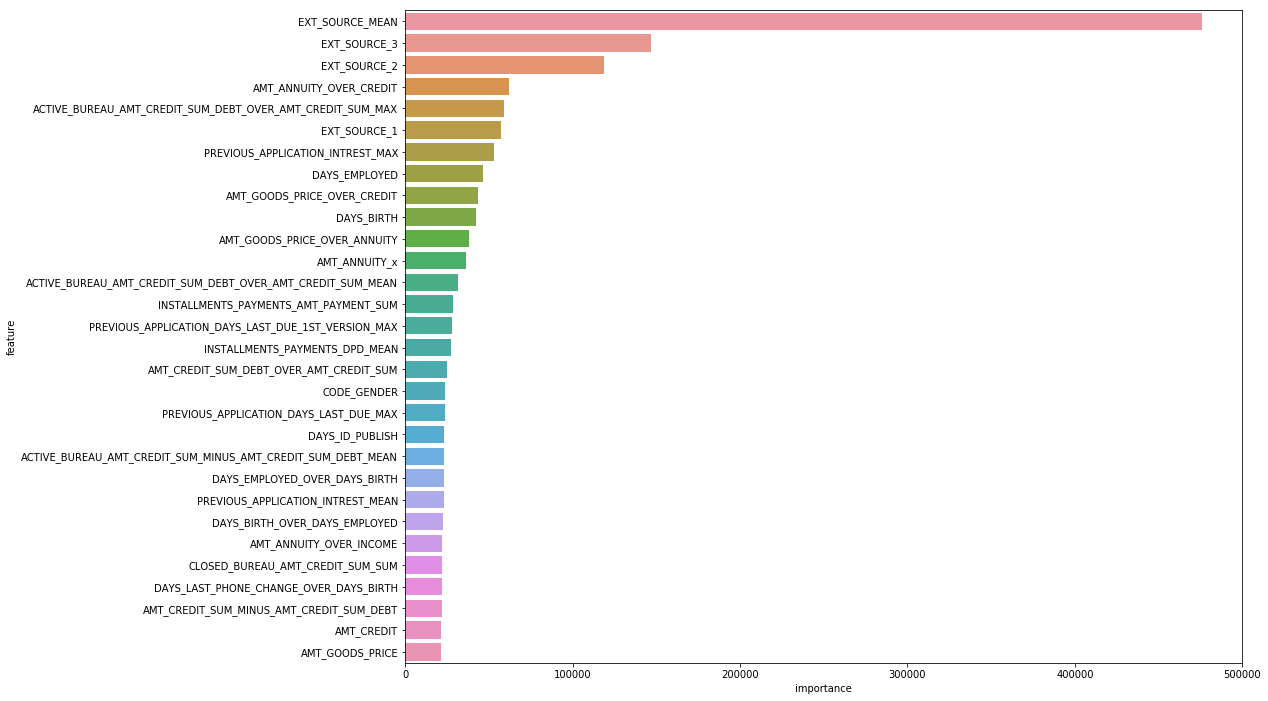

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

importance = clf.fit(X_train, y_train).feature_importances_
feature_importance = pd.DataFrame()
feature_importance['feature'] = X_train.columns.values
feature_importance['importance'] = importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(15, 12))
sns.barplot(data=feature_importance[:30], x='importance', y='feature')
plt.show()

### Make submission

In [17]:
test_id = app_test['SK_ID_CURR']
y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
y_pred = pd.Series(y_pred, name='TARGET')
sub = pd.concat([test_id, y_pred], axis=1)
sub.to_csv('sub.csv', index=False)